In [2]:
! pip install numpy

  Using cached numpy-2.2.3-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.3-cp313-cp313-macosx_14_0_arm64.whl (5.1 MB)


In [17]:
import numpy as np

In [2]:
import json


bike_data = []
run_data = []
key_list = ['speed', 'sport', 'heart_rate', 'userId', 'gender', 'id', 'altitude', 'timestamp']

with open('endomondoHR.json') as f:
    for line in f:
        d = json.loads(line.replace("'", "\""))
        if d.get('sport') is None or d.get('speed') is None:
            continue
        if d['sport'] == 'bike':
            bike_data.append({k: d[k] for k in key_list})
        elif d['sport'] == 'run':
            run_data.append({k: d[k] for k in key_list})

bike_data = np.array(bike_data)
run_data = np.array(run_data)

np.save('bike_data.npy', bike_data)
np.save('run_data.npy', run_data)

KeyboardInterrupt: 

In [18]:
bike_data = np.load('bike_data.npy', allow_pickle=True)
bike_data[0].keys()

dict_keys(['speed', 'sport', 'heart_rate', 'userId', 'gender', 'id', 'altitude', 'timestamp'])

In [19]:
import pandas as pd

bike_df = pd.DataFrame()
# use averages
bike_df['average_speed'] = [np.average(x['speed']) for x in bike_data]
bike_df['userId'] = [x['userId'] for x in bike_data]
bike_df['average_heart_rate'] = [np.average(x['heart_rate']) for x in bike_data]
bike_df['gender'] = [x['gender'] for x in bike_data]
bike_df['average_altitude'] = [np.average(x['altitude']) for x in bike_data]
bike_df['max_speed'] = [np.max(x['speed']) for x in bike_data]
bike_df['max_heart_rate'] = [np.max(x['heart_rate']) for x in bike_data]
bike_df['max_altitude'] = [np.max(x['altitude']) for x in bike_data]
bike_df

,average_speed,userId,average_heart_rate,gender,average_altitude,max_speed,max_heart_rate,max_altitude
0,26.162158,10921915,152.650,male,43.0712,57.4596,177,74.2
1,27.218369,10921915,147.710,male,35.7248,54.7704,174,67.8
2,26.050774,10921915,140.554,male,62.4256,59.2092,168,94.0
3,26.877838,10921915,147.020,male,32.6104,57.9852,178,64.0
4,27.497556,10921915,145.914,male,22.1912,57.7404,178,56.4
...,...,...,...,...,...,...,...,...
22738,24.001366,9121329,141.060,male,586.8660,75.6504,159,626.8
22739,20.605961,5547218,144.768,male,16.6976,53.0028,169,45.2
22740,11.903314,3191096,151.674,male,109.0556,19.3140,177,110.0
22741,9.221162,3191096,139.416,male,56.7184,14.3100,172,58.8


In [20]:
%pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming your DataFrame is called 'df'
X = bike_df[['average_speed', 'userId', 'gender']]
y = bike_df['average_heart_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Note: you may need to restart the kernel to use updated packages.


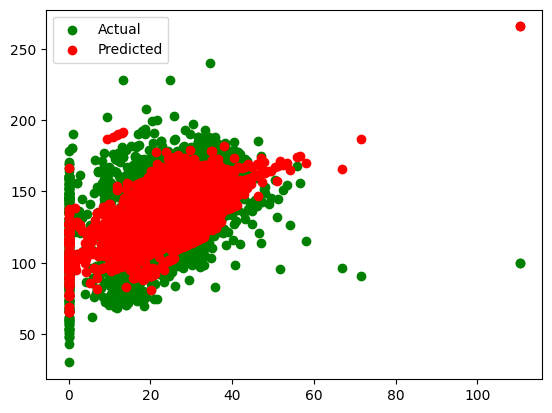

In [26]:
import matplotlib.pyplot as plt

# Define the preprocessing steps
numeric_features = ['average_speed']
categorical_features = ['userId', 'gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline that combines preprocessing and model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, y_train

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

plt.scatter(X_train['average_speed'], y_train, color='g', label='Actual')
plt.scatter(X_train['average_speed'], y_pred, color='r', label='Predicted')
# plt.plot(X_train['average_speed'], y_pred, color='k', alpha=0.5, label='Regression Line')

plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import root_mean_squared_error

y_pred = model.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean squared error: {mse:.2f}")
print(f"R-squared score: {r2:.2f}")


Root Mean squared error: 11.17
R-squared score: 0.50


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df is your DataFrame
X = bike_df[['average_speed', 'userId', 'gender']]
y = bike_df['average_heart_rate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = ['average_speed']
categorical_features = ['userId', 'gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameter search space
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Perform randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                   n_iter=20, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


KeyboardInterrupt: 

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming your DataFrame is called 'df'
X = bike_df[['average_speed', 'average_altitude', 'userId', 'gender']]
y = bike_df['average_heart_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing steps
numeric_features = ['average_speed', 'average_altitude']
categorical_features = ['userId', 'gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline that combines preprocessing and model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.2f}")
print(f"R-squared score: {r2:.2f}")

# # Example: Predict heart rate for a new data point
# new_data = pd.DataFrame({
#     'average_speed': [15.5],
#     'average_altitude': [500],  # Added average_altitude
#     'userId': ['user123'],
#     'gender': ['male']
# })

# predicted_heart_rate = model.predict(new_data)
# print(f"Predicted heart rate: {predicted_heart_rate[0]:.2f}")


Mean squared error: 134.69
R-squared score: 0.51


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df is your DataFrame
X = bike_df[['average_speed', 'average_altitude', 'userId', 'gender']]
y = bike_df['average_heart_rate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = ['average_speed', 'average_altitude']
categorical_features = ['userId', 'gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameter search space
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Perform randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                   n_iter=20, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Example: Predict heart rate for a new data point
new_data = pd.DataFrame({
    'average_speed': [15.5],
    'average_altitude': [500],
    'userId': ['user123'],
    'gender': ['male']
})

predicted_heart_rate = best_model.predict(new_data)
print(f"Predicted heart rate: {predicted_heart_rate[0]:.2f}")

# Feature importance
feature_importance = best_model.named_steps['regressor'].feature_importances_
feature_names = (numeric_features + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(importance_df)


KeyboardInterrupt: 

In [43]:
%pip install matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



Correlation Matrix:
                    average_speed  average_altitude  average_heart_rate  \
average_speed            1.000000         -0.021122            0.418504   
average_altitude        -0.021122          1.000000            0.024349   
average_heart_rate       0.418504          0.024349            1.000000   
max_altitude            -0.014790          0.899589            0.027598   
max_speed                0.547419          0.131898            0.301268   
max_heart_rate           0.365359          0.054173            0.764059   

                    max_altitude  max_speed  max_heart_rate  
average_speed          -0.014790   0.547419        0.365359  
average_altitude        0.899589   0.131898        0.054173  
average_heart_rate      0.027598   0.301268        0.764059  
max_altitude            1.000000   0.175810        0.075174  
max_speed               0.175810   1.000000        0.437008  
max_heart_rate          0.075174   0.437008        1.000000  


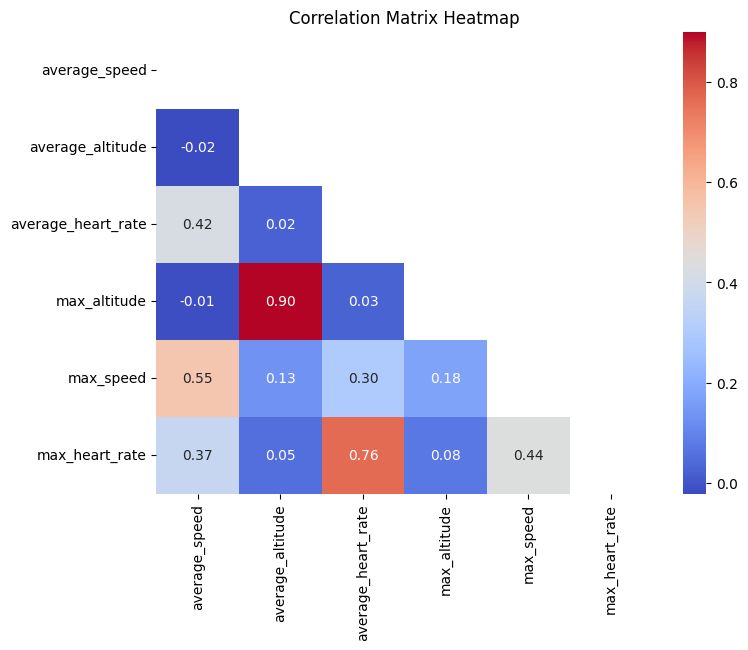

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for numerical features
correlation_matrix = bike_df[['average_speed', 'average_altitude', 'average_heart_rate', 'max_altitude', 'max_speed', 'max_heart_rate']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

matrix = np.triu(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=matrix)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [14]:
import pandas as pd

run_df = pd.DataFrame()
# use averages
run_df['average_speed'] = [np.average(x['speed']) for x in run_data]
run_df['userId'] = [x['userId'] for x in run_data]
run_df['average_heart_rate'] = [np.average(x['heart_rate']) for x in run_data]
run_df['gender'] = [x['gender'] for x in run_data]
run_df['average_altitude'] = [np.average(x['altitude']) for x in run_data]
run_df['max_speed'] = [np.max(x['speed']) for x in run_data]
run_df['max_heart_rate'] = [np.max(x['heart_rate']) for x in run_data]
run_df['max_altitude'] = [np.max(x['altitude']) for x in run_data]
run_df

,average_speed,userId,average_heart_rate,gender,average_altitude,max_speed,max_heart_rate,max_altitude
0,11.712408,279317,145.140281,female,-20.251092,23.877240,158,56.16
1,11.290800,279317,136.106212,female,505.500826,17.685413,152,543.00
2,11.886013,279317,147.553106,female,21.750180,18.209839,177,50.00
3,12.552738,279317,161.040080,female,52.409796,23.232650,176,63.00
4,11.854161,279317,155.739479,female,-0.534986,17.591589,162,3.00
...,...,...,...,...,...,...,...,...
3079,7.784151,2675116,170.006550,male,33.610917,24.037200,244,46.40
3080,7.722071,2675116,103.940594,male,37.538614,29.199600,156,55.80
3081,7.722071,2675116,103.940594,male,37.538614,29.199600,156,55.80
3082,10.710714,2675116,139.338521,male,9.937743,14.194800,178,16.60



Correlation Matrix:
                    average_speed  average_altitude  average_heart_rate  \
average_speed            1.000000          0.034583            0.283754   
average_altitude         0.034583          1.000000            0.118305   
average_heart_rate       0.283754          0.118305            1.000000   
max_altitude             0.046206          0.996067            0.120911   
max_speed                0.258151          0.096312            0.095752   
max_heart_rate           0.244985          0.133230            0.807827   

                    max_altitude  max_speed  max_heart_rate  
average_speed           0.046206   0.258151        0.244985  
average_altitude        0.996067   0.096312        0.133230  
average_heart_rate      0.120911   0.095752        0.807827  
max_altitude            1.000000   0.111211        0.139861  
max_speed               0.111211   1.000000        0.133985  
max_heart_rate          0.139861   0.133985        1.000000  


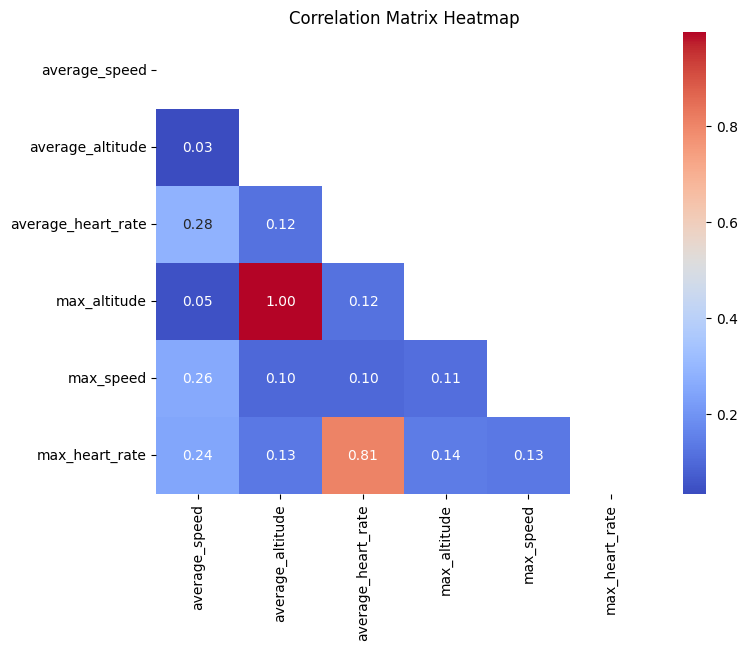

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for numerical features
correlation_matrix = run_df[['average_speed', 'average_altitude', 'average_heart_rate', 'max_altitude', 'max_speed', 'max_heart_rate']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

matrix = np.triu(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=matrix)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [64]:
sample = {}
for k, v in bike_data[0].items():
    sample[k] = [v[0]] if isinstance(v, list) else v

sample

{'speed': [6.8652],
 'sport': 'bike',
 'heart_rate': [100],
 'userId': 10921915,
 'gender': 'male',
 'id': 396826535,
 'altitude': [41.6],
 'timestamp': [1408898746]}

In [74]:
def clean_data(df):
    df = df[(df['speed'] >= 0) & (df['speed'] <= 20)]
    df = df[(df['heart_rate'] >= 40) & (df['heart_rate'] <= 200)]
    df = df[(df['altitude'] >= -100) & (df['altitude'] <= 5000)]
    return df

cleaned_bike_df = clean_data(bike_df)

gender_grouped = cleaned_bike_df.groupby('gender')[['speed', 'heart_rate', 'altitude']].mean()

print(gender_grouped)
print()

cleaned_stats = cleaned_bike_df[['speed', 'heart_rate', 'altitude']].describe()
cleaned_correlation_matrix = cleaned_bike_df[['speed', 'heart_rate', 'altitude']].corr()

print("Cleaned Basic Statistics:")
print(cleaned_stats)
print("\nCleaned Correlation Matrix:")
print(cleaned_correlation_matrix)


             speed  heart_rate    altitude
gender                                    
female   14.902347  135.379062  129.374907
male     13.904821  130.736926  176.324919
unknown  12.635626  137.219938  128.236205

Cleaned Basic Statistics:
              speed    heart_rate      altitude
count  2.222806e+06  2.222806e+06  2.222806e+06
mean   1.395257e+01  1.310020e+02  1.737049e+02
std    4.961809e+00  2.492446e+01  3.004674e+02
min    0.000000e+00  4.000000e+01 -1.000000e+02
25%    1.108440e+01  1.130000e+02  1.720000e+01
50%    1.523160e+01  1.320000e+02  6.440000e+01
75%    1.792800e+01  1.500000e+02  1.954000e+02
max    1.999969e+01  2.000000e+02  4.958600e+03

Cleaned Correlation Matrix:
               speed  heart_rate  altitude
speed       1.000000    0.041659 -0.051744
heart_rate  0.041659    1.000000  0.204178
altitude   -0.051744    0.204178  1.000000


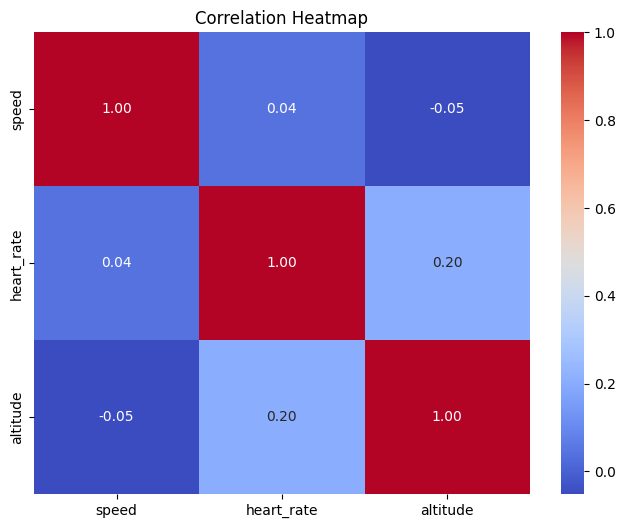

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cleaned_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

plt.title("Correlation Heatmap")
plt.show()


In [76]:
cleaned_bike_df

,speed,heart_rate,altitude,timestamp,gender,userId,speed_change,heart_rate_change,altitude_change
0,6.8652,100,41.6,2014-08-24 16:45:46,male,10921915,NaN,NaN,NaN
1,16.4736,111,40.6,2014-08-24 16:45:54,male,10921915,9.6084,11.0,-1.0
2,19.1988,120,40.6,2014-08-24 16:46:05,male,10921915,2.7252,9.0,0.0
14,14.0868,143,34.0,2014-08-24 16:49:50,male,10921915,-11.7072,0.0,0.0
33,19.4328,157,37.0,2014-08-24 16:56:01,male,10921915,-1.7784,3.0,2.6
...,...,...,...,...,...,...,...,...,...
10592154,18.2052,115,92.0,2015-05-15 19:24:23,male,3191096,-5.5440,-3.0,-1.6
10592156,19.1124,123,92.4,2015-05-15 19:24:54,male,3191096,-4.7376,-4.0,-0.4
10592159,15.4188,128,94.2,2015-05-15 19:25:39,male,3191096,-10.7820,1.0,2.0
10592164,16.6608,123,91.6,2015-05-15 19:26:54,male,3191096,-3.9636,-13.0,-2.4


In [77]:
bike_df

,speed,heart_rate,altitude,timestamp,gender,userId,speed_change,heart_rate_change,altitude_change
0,6.8652,100,41.6,2014-08-24 16:45:46,male,10921915,NaN,NaN,NaN
1,16.4736,111,40.6,2014-08-24 16:45:54,male,10921915,9.6084,11.0,-1.0
2,19.1988,120,40.6,2014-08-24 16:46:05,male,10921915,2.7252,9.0,0.0
3,20.4804,119,38.4,2014-08-24 16:46:18,male,10921915,1.2816,-1.0,-2.2
4,31.3956,120,37.0,2014-08-24 16:46:34,male,10921915,10.9152,1.0,-1.4
...,...,...,...,...,...,...,...,...,...
10592161,23.0436,134,94.0,2015-05-15 19:26:09,male,3191096,1.5120,16.0,2.0
10592162,24.7212,138,93.0,2015-05-15 19:26:24,male,3191096,1.6776,4.0,-1.0
10592163,20.6244,136,94.0,2015-05-15 19:26:39,male,3191096,-4.0968,-2.0,1.0
10592164,16.6608,123,91.6,2015-05-15 19:26:54,male,3191096,-3.9636,-13.0,-2.4


In [12]:
import numpy as np

data = np.load('run_data_with_proper_interpolate.npy', allow_pickle=True)


In [13]:
data[0].keys()

dict_keys(['time_elapsed', 'gender', 'tar_heart_rate', 'timestamp', 'id', 'heart_rate', 'sport', 'altitude', 'derived_speed', 'tar_derived_speed', 'distance', 'userId'])

In [14]:
import pandas as pd

new_df = pd.DataFrame()
# use averages
new_df['average_speed'] = [np.average(x['tar_derived_speed']) for x in data]
new_df['userId'] = [x['userId'] for x in data]
new_df['average_heart_rate'] = [np.average(x['heart_rate']) for x in data]
new_df['gender'] = [x['gender'] for x in data]
new_df['average_altitude'] = [np.average(x['altitude']) for x in data]
new_df['max_speed'] = [np.max(x['tar_derived_speed']) for x in data]
new_df['max_heart_rate'] = [np.max(x['heart_rate']) for x in data]
new_df['max_altitude'] = [np.max(x['altitude']) for x in data]
new_df

,average_speed,userId,average_heart_rate,gender,average_altitude,max_speed,max_heart_rate,max_altitude
0,8.921783,4969375,-2.686599,male,-1.872563,13.042243,0.459386,-1.677980
1,11.708271,4969375,-1.497088,male,-1.906177,14.295995,1.105480,-1.756938
2,11.368083,4969375,-2.838969,male,-1.699290,15.415711,6.839993,-1.372937
3,12.585829,4969375,-1.098245,male,-1.680131,16.454540,4.682678,-1.416988
4,10.625872,4969375,-4.309257,male,-1.661787,12.776379,4.720919,-0.664411
...,...,...,...,...,...,...,...,...
39196,9.145995,69,-0.497731,male,-2.179786,11.388645,2.393827,-1.939037
39197,8.863628,69,-1.583803,male,-2.145776,11.820148,4.886428,-1.933923
39198,8.902856,69,-1.672479,male,-2.114231,15.064148,5.661738,-1.875511
39199,10.247252,69,0.303827,male,-2.030638,21.903072,3.460443,-1.581749



Correlation Matrix:
                    average_speed  average_heart_rate  average_altitude  \
average_speed            1.000000            0.031582         -0.006693   
average_heart_rate       0.031582            1.000000          0.017158   
average_altitude        -0.006693            0.017158          1.000000   
max_speed                0.012562            0.028767         -0.008076   
max_heart_rate          -0.001841            0.702840          0.028981   
max_altitude            -0.010986            0.018400          0.987119   

                    max_speed  max_heart_rate  max_altitude  
average_speed        0.012562       -0.001841     -0.010986  
average_heart_rate   0.028767        0.702840      0.018400  
average_altitude    -0.008076        0.028981      0.987119  
max_speed            1.000000        0.047587     -0.005555  
max_heart_rate       0.047587        1.000000      0.034285  
max_altitude        -0.005555        0.034285      1.000000  


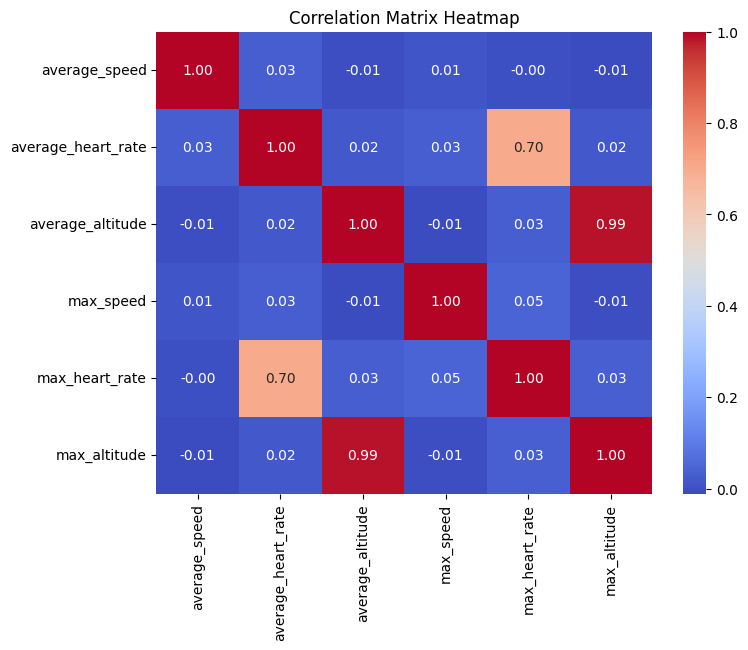

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = new_df[['average_speed', 'average_heart_rate', 'average_altitude', 'max_speed', 'max_heart_rate', 'max_altitude']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

matrix = np.triu(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create DataFrame
new_df = pd.DataFrame()
new_df['average_speed'] = [np.mean(x['tar_derived_speed']) for x in data]
new_df['average_heart_rate'] = [np.mean(x['tar_heart_rate']) for x in data]
new_df['average_altitude'] = [np.mean(x['altitude']) for x in data]
new_df['max_speed'] = [np.max(x['tar_derived_speed']) for x in data]
new_df['max_heart_rate'] = [np.max(x['tar_heart_rate']) for x in data]
new_df['max_altitude'] = [np.max(x['altitude']) for x in data]

scaler = StandardScaler()
new_df_scaled = pd.DataFrame(scaler.fit_transform(new_df), columns=new_df.columns)

# Compute correlation matrix (excluding non-numeric columns)
correlation_matrix = new_df_scaled.corr(method='spearman')
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Create heatmap
plt.figure(figsize=(12, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Correlation Matrix Heatmap')
plt.show()